In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/AnalysisBySynthesis-master

/content/drive/MyDrive/AnalysisBySynthesis-master


In [ ]:
!pip install foolbox

In [ ]:
!pip install tensorboardX

     |████████████████████████████████| 124 kB 4.1 MB/s 


In [ ]:
from itertools import repeat, chain, islice
from torch.utils.data import Sampler
import argparse
import torch
from os.path import join
import numpy as np
from torch.utils.data import DataLoader, SubsetRandomSampler
from torchvision import datasets, transforms
import warnings
import tqdm
from torchvision.utils import make_grid
from torch import nn, optim
from tensorboardX import SummaryWriter
import torchvision
import matplotlib.pyplot as plt
import sys
sys.argv=['']
del sys
import os
from torch.autograd import Variable


In [ ]:
batch_size=128
test_batch_size=32
epochs=5
lr=0.001
momentum=0.5
log_interval=10
seed=1

In [ ]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Grayscale(num_output_channels=1)
                                ])
train_dataset = datasets.CIFAR10(root= '../data', train=True, transform=transform, download=True)
test_dataset = datasets.CIFAR10(root= '../data', train=False, transform=transform, download=True)
num_train = len(train_dataset)
indices = list(range(num_train))
split = int(np.floor(0.1 * num_train))
train_idx, valid_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
valid_loader = torch.utils.data.DataLoader(train_dataset, batch_size=test_batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=test_batch_size, shuffle= True)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
##Loss Function#####
######
#######

def samplewise_loss_function(x, rec_x, mu, logvar, beta):
    """This is the loss function used during inference to calculate the logits.
    This function must only operate on the last the dimensions of x and rec_x.
    There can be varying number of additional dimensions before them!
    """
    input_size = int(np.prod(x.shape[-3:]))
    if len(x.shape) == 5 and len(rec_x.shape) == 5 and x.shape[1] == 1 and rec_x.shape[0] == 1:
        # alternative implementation that is much faster and more memory efficient
        # when each sample in x needs to be compared to each sample in rec_x
        assert x.shape[-3:] == rec_x.shape[-3:]
        x = x.reshape(x.shape[0], input_size)
        y = rec_x.reshape(rec_x.shape[1], input_size)

        x2 = torch.norm(x, p=2, dim=-1, keepdim=True).pow(2)
        y2 = torch.norm(y, p=2, dim=-1, keepdim=True).pow(2)
        # note that we could cache the calculation of y2, but
        # it's so fast that it doesn't matter

        L2squared = x2 + y2.t() - 2 * torch.mm(x, y.t())
        L2squared = L2squared / input_size
    else:
        if len(x.shape) != 4 or x.shape != rec_x.shape:
            warnings.warn('samplewise_loss_function possibly not been optimized for this')
            raise

        d = rec_x - x
        d.pow_(2)
        L2squared = d.sum((-1, -2, -3)) / input_size
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=((-1, -2, -3))) / input_size
    # note that the KLD sum is over the latents, not over the input size
    return L2squared + beta * KLD


def vae_loss_function(x, rec_x, mu, logvar, beta):
    """Loss function to train a VAE summed over all elements and batch."""

    L2squared = torch.sum((rec_x - x).pow(2))
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return L2squared + beta * KLD


def abs_loss_function(x, labels, recs, mus, logvars, beta):
    """Loss function of the full ABS model
    Args:
        x (Tensor): batch of inputs
        labels (Tensor): batch of labels corresponding to the inputs
        recs (Tensor): reconstruction from each VAE (dim 0) for each sample (dim 1)
        mus (Tensor): mu from each VAE (dim 0) for each sample (dim 1)
        logvars (Tensor): logvar from each VAE (dim 0) for each sample (dim 1)
    """
    N = len(x)
    C = len(recs)

    assert labels.size() == (N,)
    assert recs.size()[:2] == (C, N)
    assert mus.size()[:2] == (C, N)
    assert logvars.size()[:2] == (C, N)

    assert labels.min().item() >= 0
    assert labels.max().item() < C

    loss = 0
    for c, rec, mu, logvar in zip(range(C), recs, mus, logvars):
        # train each VAE on samples from one class
        mask = (labels == c)
        if mask.sum().item() == 0:
            # batch does not contain samples for this VAE
            continue
        loss += vae_loss_function(x[mask], rec[mask], mu[mask], logvar[mask], beta) / N
    return loss

In [ ]:
class RobustInference(nn.Module):
    """Takes a trained ABS model and replaces its variational inference
    with robust inference."""

    def __init__(self, abs_model, device, n_samples, n_iterations, *, fraction_to_dismiss, lr, radius):
        super().__init__()

        self.abs = abs_model
        self.vaes = abs_model.vaes
        self.lr = lr
        self.beta = abs_model.beta
        self.radius = radius
        self.name = f'{n_samples}_{n_iterations}'

        # create a set of random latents that we will reuse
        n_latents = self.vaes[0].n_latents
        self.z = self.draw_random_latents(n_samples, n_latents, fraction_to_dismiss).to(device)

        # assuming that z's were sampled from a normal distribution with mean = z, var = 1
        # note that we haven't acutally sampled z; instead z is simply mu
        self.mu = self.z
        self.logvar = torch.tensor(0.).to(device)

        self.cached_reconstructions = {}

        assert n_iterations >= 0, 'n_iterations must be non-negative'
        self.gradient_descent_iterations = n_iterations

    @staticmethod
    def draw_random_latents(n_samples, n_latents, fraction_to_dismiss):
        assert 0 <= fraction_to_dismiss < 1

        z = torch.randn(int(n_samples / (1 - fraction_to_dismiss)), n_latents, 1, 1)

        if z.size()[0] > n_samples:
            # ignore the least likely samples
            d = torch.sum(z ** 2, dim=(1, 2, 3))
            _, best = torch.sort(d)
            best = best[:n_samples]
            z = z[best]

        return z

    @staticmethod
    def clip_to_sphere_(z, radius):
        """Clips latents to a sphere. Operates in-place!
        This function assumes that the shape of z is
        (n_classes, batch_size, *latents_shape)"""

        if radius == np.inf:
            return

        # flatten the latent dimensions because torch.norm only works on one
        zr = z.reshape(z.size()[:2] + (-1,))

        length = torch.norm(zr, p=2, dim=2)

        # determine latents that are larger than desired
        mask = length > radius

        # add missing singleton dimensions to the end
        length = length.view(length.size() + (1,) * (z.dim() - length.dim()))

        z[mask] = z[mask] / length[mask] * radius

    def invalidate_cache(self):
        self.cached_reconstructions = {}

    def forward(self, x):
        """This performs robust inference by finding the optimal latents for
        each VAE using optimization rather than the encoder network."""

        with torch.no_grad():
            losses = []
            recs = []
            mus = []
            for vae in self.vaes:
                # pass the random latents through the VAEs
                if vae not in self.cached_reconstructions:
                    self.cached_reconstructions[vae] = vae.decoder(self.z)
                rec = self.cached_reconstructions[vae]

                # determine the best latents for each sample in x given this VAE
                # -> add a second batch dimension to x that will be broadcasted to the number of reconstructions
                # -> add a second batch dimension to rec that will be broadcasted to the number of inputs in x
                loss = samplewise_loss_function(x.unsqueeze(1), rec.unsqueeze(0), self.mu, self.logvar, self.beta)
                assert loss.dim() == 2
                # take min over samples in z
                loss, indices = loss.min(dim=1)

                losses.append(loss)
                recs.append(rec[indices])
                mus.append(self.mu[indices])

            mus = torch.stack(mus)

            if self.gradient_descent_iterations > 0:
                # for each sample and VAE, try to improve the best latents
                # further using gradient descent
                mus = self.gradient_descent(x, mus)

                # update losses and recs
                recs = [vae.decoder(mu) for vae, mu in zip(self.vaes, mus)]
                losses = [samplewise_loss_function(x, rec, mu, self.logvar, self.beta)
                          for rec, mu in zip(recs, mus)]

            recs = torch.stack(recs)
            losses = torch.stack(losses)

            logits = -losses.transpose(0, 1)
            logvars = torch.zeros_like(mus)
            return logits, recs, mus, logvars

    def gradient_descent(self, x, z):
        with torch.enable_grad():
            # create a completely independent copy of z
            z = torch.tensor(z, requires_grad=True).to(z.device)
            optimizer = optim.Adam([z], lr=self.lr)

            for j in range(self.gradient_descent_iterations):
                optimizer.zero_grad()

                for vae, zi in zip(self.vaes, z):
                    rec = vae.decoder(zi)
                    loss = samplewise_loss_function(x, rec, zi, self.logvar, self.beta).sum()
                    loss.backward()

                optimizer.step()

                # must operate on .data because PyTorch doesn't allow
                # in-place modifications of a leaf Variable itself
                self.clip_to_sphere_(z.data, radius=self.radius)
        return z
        

In [ ]:
def get_args():
    parser = argparse.ArgumentParser(description='Analysis by Synthesis Model')

    parser.add_argument('--test-only', action='store_true', default=False,
                        help='same as --initial-evaluation --epochs 0')

    # control loading and saving
    parser.add_argument('--logdir', default=None, type=str,
                        help='path to the TensorBoard log directory (default: None)')
    parser.add_argument('--load', default=None, type=str,
                        help='file from which the model should be loaded')
    parser.add_argument('--save', default=None, type=str,
                        help='file to which the model should be saved (in addition to logdir)')

    # control training
    parser.add_argument('--epochs', type=int, default=10, metavar='N',
                        help='number of epochs to train (default: 10)')
    parser.add_argument('--batch-size', type=int, default=128, metavar='N',
                        help='input batch size for training (default: 128)')
    parser.add_argument('--lr', type=float, default=3e-3, metavar='alpha',
                        help='learning rate for training')

    # control loss function
    parser.add_argument('--beta', type=float, default=1,
                        help='scaling factor for the KLD loss term')

    # control logging and evaluation
    parser.add_argument('--initial-evaluation', action='store_true', default=False,
                        help='perform an initial evaluation before training')
    parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                        help='how many batches to wait before logging training status')
    parser.add_argument('--epochs-full-evaluation', type=int, default=10, metavar='N',
                        help='how many epochs to wait before a full (expensive) evaluation')

    # control dataset
    parser.add_argument('--dataset', default='cifar', type=str,
                        help='dataset to use, e.g. mnist, cifar, gtsrb (default:mnist)')
    parser.add_argument('--no-balancing', action='store_true', default=False,
                        help='disables class balancing in batches')
    parser.add_argument('--no-augmentation', action='store_true', default=False,
                        help='disables data augmentation')

    # control inference
    parser.add_argument('--inference-lr', type=float, default=5e-2,
                        help='learning rate for Adam during inference')
    parser.add_argument('--fraction-to-dismiss', type=float, default=0.1,
                        help='increases number of random samples and then ignores the least likely ones')
    parser.add_argument('--clip-to-sphere', type=float, default=5,
                        help='limit on the norm of the latents when doing gradient descent during inference')
    parser.add_argument('--seed', type=int, default=1, metavar='S',
                        help='random seed (default: 1)')

    # control performance
    parser.add_argument('--no-cuda', action='store_true', default=False,
                        help='disables CUDA training')
    parser.add_argument('--test-batch-size', type=int, default=10000, metavar='N',
                        help='input batch size for testing (default: 10000)')
    parser.add_argument('--num-workers', type=int, default=4, metavar='N',
                        help='number of workers to load data (default: 4)')

    args = parser.parse_args()
    return args

In [ ]:
def sample(model, device, step, writer):
  if writer is None:
    return
  model.eval()
  n_latents = model.vaes[0].n_latents
  with torch.no_grad():
    zs = torch.randn(12, n_latents, 1, 1).to(device)
    samples = torch.cat([vae.decoder(zs).cpu() for vae in model.vaes])
    grid = make_grid(samples, nrow=12)
    writer.add_image(f'samples', grid, step)

In [ ]:
def count_correct(predictions, labels):
  assert predictions.dim() == 2
  assert labels.dim() == 1

  predictions = torch.argmax(predictions, dim=1)
  correct = (predictions == labels).sum().item()
  return correct

In [ ]:
class Encoder(nn.Module):
    def __init__(self, n_latents):
        super().__init__()

        self.shared = nn.Sequential(
            nn.Conv2d(1, 32, 5),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 32, 4, stride=2),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.Conv2d(32, 64, 3, stride=2),
            nn.BatchNorm2d(64),
            nn.ELU(),
        )

        self.conv_mu = nn.Conv2d(64, n_latents, 5)
        self.conv_logvar = nn.Conv2d(64, n_latents, 5)

    def forward(self, x):
        shared = self.shared(x)
        mu = self.conv_mu(shared)
        logvar = self.conv_logvar(shared)
        return mu, logvar


class Decoder(nn.Module):
    def __init__(self, n_latents):
        super().__init__()

        self.layers = nn.Sequential(
            nn.ConvTranspose2d(n_latents, 32, 4),
            nn.BatchNorm2d(32),
            nn.ELU(),
            nn.ConvTranspose2d(32, 16, 5, stride=2),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.ConvTranspose2d(16, 16, 5, stride=2),
            nn.BatchNorm2d(16),
            nn.ELU(),
            nn.ConvTranspose2d(16, 1, 4),
            nn.Sigmoid(),
        )

    def forward(self, x):
        return self.layers(x)


class VAE(nn.Module):
    def __init__(self, n_latents):
        super().__init__()

        self.n_latents = n_latents
        self.encoder = Encoder(self.n_latents)
        self.decoder = Decoder(self.n_latents)

    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(0.5 * logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        return self.decoder(z), mu, logvar


class ABS(nn.Module):
    """ABS model implementation that performs variational inference
    and can be used for training."""

    def __init__(self, n_classes, n_latents_per_class, beta):
        super().__init__()

        self.beta = beta
        self.vaes = nn.ModuleList([VAE(n_latents_per_class) for _ in range(n_classes)])

    def forward(self, x):
        outputs = [vae(x) for vae in self.vaes]
        recs, mus, logvars = zip(*outputs)
        recs, mus, logvars = torch.stack(recs), torch.stack(mus), torch.stack(logvars)
        losses = [samplewise_loss_function(x, *output, self.beta) for output in outputs]
        losses = torch.stack(losses)
        assert losses.dim() == 2
        logits = -losses.transpose(0, 1)
        return logits, recs, mus, logvars

In [ ]:
'''beta=1
def train(model, optimizer, epoch, loader):
    for batch_idx, (data, target) in enumerate(loader):
        data, target = Variable(data), Variable(target)
        optimizer.zero_grad() # Removes all past gradient run info (clean up)
        logits, recs, mus, logvars = model(data)
        loss = abs_loss_function(data, target, recs, mus, logvars, beta)
        loss.backward() # Run backprop to update weights
        optimizer.step() # Take a step in the right direction of the SGD
        if batch_idx == 0:
          # up to 8 samples
          n = min(data.size(0), 10)

          # flatten VAE and batch dim into a single dim
          shape = (-1,) + recs.size()[2:]

          grid = torch.cat([data[:n], recs[:, :n].reshape(shape)])
          grid = make_grid(grid, nrow=n)

        # Logging
        length = len(loader.dataset)
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch_idx * len(data), len(loader.dataset),100. * batch_idx / len(loader), loss.data))
     
'''

"beta=1\ndef train(model, optimizer, epoch, loader):\n    for batch_idx, (data, target) in enumerate(loader):\n        data, target = Variable(data), Variable(target)\n        optimizer.zero_grad() # Removes all past gradient run info (clean up)\n        logits, recs, mus, logvars = model(data)\n        loss = abs_loss_function(data, target, recs, mus, logvars, beta)\n        loss.backward() # Run backprop to update weights\n        optimizer.step() # Take a step in the right direction of the SGD\n        if batch_idx == 0:\n          # up to 8 samples\n          n = min(data.size(0), 10)\n\n          # flatten VAE and batch dim into a single dim\n          shape = (-1,) + recs.size()[2:]\n\n          grid = torch.cat([data[:n], recs[:, :n].reshape(shape)])\n          grid = make_grid(grid, nrow=n)\n\n        # Logging\n        length = len(loader.dataset)\n        if batch_idx % log_interval == 0:\n            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch, batch

In [ ]:
loss_=[]
acc=[]

def train(model, args, device, train_loader, optimizer, epoch, writer=None):
    model.train()

    epoch_loss = 0
    epoch_correct = 0
    

    for batch_idx, (data, targets) in enumerate(train_loader):
        # training
        data = data.to(device)
        targets = targets.to(device)
        optimizer.zero_grad()
        logits, recs, mus, logvars = model(data)
        loss = abs_loss_function(data, targets, recs, mus, logvars, args.beta)
        loss.backward()
        optimizer.step()

        # logging
        loss = loss.item()
        epoch_loss += loss * len(data)
        correct = count_correct(logits, targets)
        accuracy = 100 * correct / len(data)
        epoch_correct += correct

        if writer is not None:
            step = (epoch - 1) * len(train_loader.sampler) + batch_idx * args.batch_size
            writer.add_scalar('loss/train', loss, step)
            writer.add_scalar('accuracy/train', accuracy, step)

            if batch_idx == 0:
                # up to 8 samples
                n = min(data.size(0), 10)

                # flatten VAE and batch dim into a single dim
                shape = (-1,) + recs.size()[2:]

                grid = torch.cat([data[:n], recs[:, :n].reshape(shape)])
                grid = make_grid(grid, nrow=n)
                writer.add_image(f'reconstructions/train', grid, step)

        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{:5d}/{} ({:2.0f}%)]\tLoss: {:3.4f} ({:2.0f}%)'.format(
                epoch, batch_idx * args.batch_size, len(train_loader.sampler),
                100 * batch_idx / len(train_loader), loss, accuracy))

    epoch_loss /= len(train_loader.sampler)
    epoch_accuracy = epoch_correct / len(train_loader.sampler)
    loss_.append(epoch_loss)
    acc.append(epoch_accuracy)
    if writer is not None:
        step = epoch * len(train_loader.sampler)
        writer.add_scalar('loss/train-epoch', epoch_loss, step)
        writer.add_scalar('accuracy/train-epoch', epoch_accuracy, step)
    print(f'====> Epoch: {epoch} Average loss: {epoch_loss:.4f}, accuracy: {epoch_accuracy * 100:.3f}')

In [ ]:
'''Accuracy=[]
def test(model, loader, name):
    test_loss = 0
    correct = 0
    for data, target in loader:
        data, target = Variable(data, volatile=True), Variable(target)
        output = model(data) # Runs the model
        test_loss += F.nll_loss(output, target, size_average=False).item() # Sum up batch loss
        pred = output.data.max(1, keepdim=True)[1] # Get the index (label) of the max log-probability
        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()

    # Logging
    length = len(list(loader)) * test_batch_size
    test_loss /= length
    print('\n', name, 'set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, length,100. * correct / length))
    accu=float(correct/length)
    Accuracy.append(accu)
    print(name,' set Accuracy over the epochs',Accuracy)
    return test_loss'''

"Accuracy=[]\ndef test(model, loader, name):\n    test_loss = 0\n    correct = 0\n    for data, target in loader:\n        data, target = Variable(data, volatile=True), Variable(target)\n        output = model(data) # Runs the model\n        test_loss += F.nll_loss(output, target, size_average=False).item() # Sum up batch loss\n        pred = output.data.max(1, keepdim=True)[1] # Get the index (label) of the max log-probability\n        correct += pred.eq(target.data.view_as(pred)).long().cpu().sum()\n\n    # Logging\n    length = len(list(loader)) * test_batch_size\n    test_loss /= length\n    print('\n', name, 'set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(test_loss, correct, length,100. * correct / length))\n    accu=float(correct/length)\n    Accuracy.append(accu)\n    print(name,' set Accuracy over the epochs',Accuracy)\n    return test_loss"

In [ ]:
def test(model, args, device, test_loader, step, writer=None, max_batches=None):
    model.eval()
    suffix = '-' + model.name if hasattr(model, 'name') else ''

    N = len(test_loader.dataset)

    loss = 0
    correct = 0

    with torch.no_grad():
        # using a context manager for tqdm prevents messed up console outputs
        with tqdm.tqdm(test_loader) as t:
            for i, (data, targets) in enumerate(t):
                data = data.to(device)
                targets = targets.to(device)
                logits, recs, mus, logvars = model(data)
                loss += abs_loss_function(data, targets, recs, mus, logvars, args.beta).item() * len(data)
                correct += count_correct(logits, targets)

                if i == 0 and writer is not None:
                    # up to 8 samples
                    n = min(data.size(0), 8)
                    # flatten VAE and batch dim into a single dim
                    shape = (-1,) + recs.size()[2:]
                    grid = torch.cat([data[:n], recs[:, :n].reshape(shape)])
                    grid = make_grid(grid, nrow=n)
                    writer.add_image(f'reconstructions/test{suffix}', grid, step)

                if i == max_batches:
                    # limit testing to a subset by passing max_batches
                    N = i * args.test_batch_size + len(data)
                    break

    loss /= N
    accuracy = 100 * correct / N
    print(f'====> Test set: Average loss: {loss:.4f}, Accuracy: {correct}/{N} ({accuracy:.0f}%) {suffix[1:]}\n')

    if writer is not None:
        writer.add_scalar(f'loss/test{suffix}', loss, step)
        writer.add_scalar(f'accuracy/test{suffix}', accuracy, step)

In [ ]:
compute_mode = 'cpu'

if compute_mode == 'cpu':
    device = torch.device('cpu')
elif compute_mode == 'gpu':
    # If you are using pytorch on the GPU cluster, you have to manually specify which GPU device to use
    # It is extremely important that you *do not* spawn multi-GPU jobs.
    os.environ["CUDA_VISIBLE_DEVICES"] = '0'    # Set device ID here
    device = torch.device('cuda')
else:
    raise ValueError('Unrecognized compute mode')

In [ ]:
model= ABS(n_classes=10, n_latents_per_class=8, beta=1).to(device)
args= get_args()

kwargs = {
        'fraction_to_dismiss': args.fraction_to_dismiss,
        'lr': args.inference_lr,
        'radius': args.clip_to_sphere,
        
    }
robust_inference1 = RobustInference(model, device, n_samples=80, n_iterations=0, **kwargs)
robust_inference2 = RobustInference(model, device, n_samples=8000, n_iterations=0, **kwargs)
robust_inference3 = RobustInference(model, device, n_samples=8000, n_iterations=50, **kwargs)

# create optimizer
optimizer = optim.Adam(model.parameters(), lr=args.lr)

# create writer for TensorBoard
writer = SummaryWriter(args.logdir) if args.logdir is not None else None


In [ ]:
#args= get_args()
first_epoch = 0 if args.initial_evaluation else 1
samples_per_epoch = len(train_loader.sampler)
for epoch in range(first_epoch, args.epochs + 1):
  if epoch > 0:
    # train for one epoch
    train(model, args, device, train_loader, optimizer, epoch, writer=writer)

    # model changed, so make sure reconstructions are regenerated
    #robust_inference1.invalidate_cache()
    #robust_inference2.invalidate_cache()
    #robust_inference3.invalidate_cache()

  step = epoch * samples_per_epoch

  # common params for calls to test
  params = (args, device, test_loader, step, writer)

  # some evaluations can happen after every epoch because they are cheap
  test(model, *params)
  #test(robust_inference1, *params)
  #test(robust_inference2, *params)

  # expensive evaluations happen from time to time and at the end
  if epoch % args.epochs_full_evaluation == 0 or epoch == args.epochs:
    #test(robust_inference3, *params)
    test(model, *params)

  sample(model, device, step, writer)

# save the model
if args.logdir is not None:
  path = join(args.logdir, 'model.pth')
  torch.save(model.state_dict(), path)
  print(f'model saved to {path}')

if args.save is not None:
  torch.save(model.state_dict(), args.save)
  print(f'model saved to {args.save}')

if writer is not None:
  writer.close()

Train Epoch: 1 [    0/45000 ( 0%)]	Loss: 37.6212 (21%)
Train Epoch: 1 [ 1280/45000 ( 3%)]	Loss: 38.5821 (28%)
Train Epoch: 1 [ 2560/45000 ( 6%)]	Loss: 38.5584 (28%)
Train Epoch: 1 [ 3840/45000 ( 9%)]	Loss: 37.1960 (24%)
Train Epoch: 1 [ 5120/45000 (11%)]	Loss: 38.0662 (27%)
Train Epoch: 1 [ 6400/45000 (14%)]	Loss: 39.1488 (23%)
Train Epoch: 1 [ 7680/45000 (17%)]	Loss: 36.8818 (19%)
Train Epoch: 1 [ 8960/45000 (20%)]	Loss: 37.0055 (22%)
Train Epoch: 1 [10240/45000 (23%)]	Loss: 37.3688 (21%)
Train Epoch: 1 [11520/45000 (26%)]	Loss: 39.5742 (31%)
Train Epoch: 1 [12800/45000 (28%)]	Loss: 40.2047 (21%)
Train Epoch: 1 [14080/45000 (31%)]	Loss: 37.3661 (28%)
Train Epoch: 1 [15360/45000 (34%)]	Loss: 35.9277 (23%)
Train Epoch: 1 [16640/45000 (37%)]	Loss: 37.1387 (27%)
Train Epoch: 1 [17920/45000 (40%)]	Loss: 36.9299 (27%)
Train Epoch: 1 [19200/45000 (43%)]	Loss: 35.9744 (23%)
Train Epoch: 1 [20480/45000 (45%)]	Loss: 38.3031 (21%)
Train Epoch: 1 [21760/45000 (48%)]	Loss: 37.8491 (20%)
Train Epoc

100%|██████████| 313/313 [01:16<00:00,  4.09it/s]


====> Test set: Average loss: 31.0705, Accuracy: 3089/10000 (31%) 

Train Epoch: 2 [    0/45000 ( 0%)]	Loss: 36.2869 (21%)
Train Epoch: 2 [ 1280/45000 ( 3%)]	Loss: 38.4614 (23%)
Train Epoch: 2 [ 2560/45000 ( 6%)]	Loss: 38.2038 (23%)
Train Epoch: 2 [ 3840/45000 ( 9%)]	Loss: 38.5420 (30%)
Train Epoch: 2 [ 5120/45000 (11%)]	Loss: 37.6099 (27%)
Train Epoch: 2 [ 6400/45000 (14%)]	Loss: 35.8734 (21%)
Train Epoch: 2 [ 7680/45000 (17%)]	Loss: 35.9506 (23%)
Train Epoch: 2 [ 8960/45000 (20%)]	Loss: 37.9229 (23%)
Train Epoch: 2 [10240/45000 (23%)]	Loss: 35.2608 (24%)
Train Epoch: 2 [11520/45000 (26%)]	Loss: 39.6183 (19%)
Train Epoch: 2 [12800/45000 (28%)]	Loss: 36.9246 (21%)
Train Epoch: 2 [14080/45000 (31%)]	Loss: 37.1113 (20%)
Train Epoch: 2 [15360/45000 (34%)]	Loss: 36.2154 (24%)
Train Epoch: 2 [16640/45000 (37%)]	Loss: 38.1721 (22%)
Train Epoch: 2 [17920/45000 (40%)]	Loss: 36.8150 (21%)
Train Epoch: 2 [19200/45000 (43%)]	Loss: 35.6185 (20%)
Train Epoch: 2 [20480/45000 (45%)]	Loss: 36.1008 (23

100%|██████████| 313/313 [01:17<00:00,  4.03it/s]


====> Test set: Average loss: 30.4177, Accuracy: 3304/10000 (33%) 

Train Epoch: 3 [    0/45000 ( 0%)]	Loss: 37.1589 (24%)
Train Epoch: 3 [ 1280/45000 ( 3%)]	Loss: 33.8978 (28%)
Train Epoch: 3 [ 2560/45000 ( 6%)]	Loss: 37.1056 (19%)
Train Epoch: 3 [ 3840/45000 ( 9%)]	Loss: 35.7141 (23%)
Train Epoch: 3 [ 5120/45000 (11%)]	Loss: 35.3150 (37%)
Train Epoch: 3 [ 6400/45000 (14%)]	Loss: 35.6747 (29%)
Train Epoch: 3 [ 7680/45000 (17%)]	Loss: 37.2322 (23%)
Train Epoch: 3 [ 8960/45000 (20%)]	Loss: 36.1487 (23%)
Train Epoch: 3 [10240/45000 (23%)]	Loss: 37.2046 (30%)
Train Epoch: 3 [11520/45000 (26%)]	Loss: 35.8976 (26%)
Train Epoch: 3 [12800/45000 (28%)]	Loss: 37.5637 (28%)
Train Epoch: 3 [14080/45000 (31%)]	Loss: 35.5418 (30%)
Train Epoch: 3 [15360/45000 (34%)]	Loss: 38.4608 (23%)
Train Epoch: 3 [16640/45000 (37%)]	Loss: 35.3033 (26%)
Train Epoch: 3 [17920/45000 (40%)]	Loss: 35.8304 (23%)
Train Epoch: 3 [19200/45000 (43%)]	Loss: 34.9424 (22%)
Train Epoch: 3 [20480/45000 (45%)]	Loss: 34.2623 (25

100%|██████████| 313/313 [01:12<00:00,  4.31it/s]


====> Test set: Average loss: 30.3550, Accuracy: 3084/10000 (31%) 

Train Epoch: 4 [    0/45000 ( 0%)]	Loss: 34.6421 (33%)
Train Epoch: 4 [ 1280/45000 ( 3%)]	Loss: 38.4322 (25%)
Train Epoch: 4 [ 2560/45000 ( 6%)]	Loss: 37.2139 (19%)
Train Epoch: 4 [ 3840/45000 ( 9%)]	Loss: 37.8262 (23%)
Train Epoch: 4 [ 5120/45000 (11%)]	Loss: 37.4722 (27%)
Train Epoch: 4 [ 6400/45000 (14%)]	Loss: 33.9808 (24%)
Train Epoch: 4 [ 7680/45000 (17%)]	Loss: 34.1687 (26%)
Train Epoch: 4 [ 8960/45000 (20%)]	Loss: 35.3122 (26%)
Train Epoch: 4 [10240/45000 (23%)]	Loss: 38.0453 (27%)
Train Epoch: 4 [11520/45000 (26%)]	Loss: 36.1117 (21%)
Train Epoch: 4 [12800/45000 (28%)]	Loss: 37.1902 (27%)
Train Epoch: 4 [14080/45000 (31%)]	Loss: 34.5033 (27%)
Train Epoch: 4 [15360/45000 (34%)]	Loss: 37.8188 (26%)
Train Epoch: 4 [16640/45000 (37%)]	Loss: 32.6239 (24%)
Train Epoch: 4 [17920/45000 (40%)]	Loss: 33.2935 (23%)
Train Epoch: 4 [19200/45000 (43%)]	Loss: 34.7736 (30%)
Train Epoch: 4 [20480/45000 (45%)]	Loss: 35.5724 (22

100%|██████████| 313/313 [01:13<00:00,  4.28it/s]


====> Test set: Average loss: 29.7960, Accuracy: 3362/10000 (34%) 

Train Epoch: 5 [    0/45000 ( 0%)]	Loss: 36.8022 (23%)
Train Epoch: 5 [ 1280/45000 ( 3%)]	Loss: 36.8687 (27%)
Train Epoch: 5 [ 2560/45000 ( 6%)]	Loss: 35.9752 (23%)
Train Epoch: 5 [ 3840/45000 ( 9%)]	Loss: 35.3275 (32%)
Train Epoch: 5 [ 5120/45000 (11%)]	Loss: 37.6022 (27%)
Train Epoch: 5 [ 6400/45000 (14%)]	Loss: 36.7029 (25%)
Train Epoch: 5 [ 7680/45000 (17%)]	Loss: 34.3863 (27%)
Train Epoch: 5 [ 8960/45000 (20%)]	Loss: 35.3690 (27%)
Train Epoch: 5 [10240/45000 (23%)]	Loss: 35.9993 (26%)
Train Epoch: 5 [11520/45000 (26%)]	Loss: 36.3167 (30%)
Train Epoch: 5 [12800/45000 (28%)]	Loss: 37.3629 (28%)
Train Epoch: 5 [14080/45000 (31%)]	Loss: 34.8574 (30%)
Train Epoch: 5 [15360/45000 (34%)]	Loss: 33.9419 (23%)
Train Epoch: 5 [16640/45000 (37%)]	Loss: 34.3678 (23%)
Train Epoch: 5 [17920/45000 (40%)]	Loss: 36.7701 (23%)
Train Epoch: 5 [19200/45000 (43%)]	Loss: 36.9021 (27%)
Train Epoch: 5 [20480/45000 (45%)]	Loss: 36.1586 (26

100%|██████████| 313/313 [01:17<00:00,  4.02it/s]


====> Test set: Average loss: 30.1421, Accuracy: 3366/10000 (34%) 

Train Epoch: 6 [    0/45000 ( 0%)]	Loss: 36.9917 (22%)
Train Epoch: 6 [ 1280/45000 ( 3%)]	Loss: 35.4148 (18%)
Train Epoch: 6 [ 2560/45000 ( 6%)]	Loss: 35.8176 (23%)
Train Epoch: 6 [ 3840/45000 ( 9%)]	Loss: 36.2933 (23%)
Train Epoch: 6 [ 5120/45000 (11%)]	Loss: 36.2477 (23%)
Train Epoch: 6 [ 6400/45000 (14%)]	Loss: 35.9932 (26%)
Train Epoch: 6 [ 7680/45000 (17%)]	Loss: 39.0119 (17%)
Train Epoch: 6 [ 8960/45000 (20%)]	Loss: 36.3885 (23%)
Train Epoch: 6 [10240/45000 (23%)]	Loss: 34.0382 (25%)
Train Epoch: 6 [11520/45000 (26%)]	Loss: 35.0533 (34%)
Train Epoch: 6 [12800/45000 (28%)]	Loss: 34.5866 (27%)
Train Epoch: 6 [14080/45000 (31%)]	Loss: 35.9306 (22%)
Train Epoch: 6 [15360/45000 (34%)]	Loss: 35.3496 (26%)
Train Epoch: 6 [16640/45000 (37%)]	Loss: 36.9273 (25%)
Train Epoch: 6 [17920/45000 (40%)]	Loss: 35.3453 (27%)
Train Epoch: 6 [19200/45000 (43%)]	Loss: 34.0608 (28%)
Train Epoch: 6 [20480/45000 (45%)]	Loss: 35.8991 (22

100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


====> Test set: Average loss: 30.1620, Accuracy: 3303/10000 (33%) 

Train Epoch: 7 [    0/45000 ( 0%)]	Loss: 38.6125 (25%)
Train Epoch: 7 [ 1280/45000 ( 3%)]	Loss: 36.1649 (27%)
Train Epoch: 7 [ 2560/45000 ( 6%)]	Loss: 36.7134 (23%)
Train Epoch: 7 [ 3840/45000 ( 9%)]	Loss: 35.0016 (27%)
Train Epoch: 7 [ 5120/45000 (11%)]	Loss: 36.5088 (25%)
Train Epoch: 7 [ 6400/45000 (14%)]	Loss: 37.2073 (24%)
Train Epoch: 7 [ 7680/45000 (17%)]	Loss: 34.3953 (24%)
Train Epoch: 7 [ 8960/45000 (20%)]	Loss: 35.8678 (26%)
Train Epoch: 7 [10240/45000 (23%)]	Loss: 35.4634 (23%)
Train Epoch: 7 [11520/45000 (26%)]	Loss: 34.2439 (29%)
Train Epoch: 7 [12800/45000 (28%)]	Loss: 37.3824 (24%)
Train Epoch: 7 [14080/45000 (31%)]	Loss: 34.4488 (23%)
Train Epoch: 7 [15360/45000 (34%)]	Loss: 35.5095 (27%)
Train Epoch: 7 [16640/45000 (37%)]	Loss: 36.3484 (22%)
Train Epoch: 7 [17920/45000 (40%)]	Loss: 36.1636 (27%)
Train Epoch: 7 [19200/45000 (43%)]	Loss: 35.3748 (29%)
Train Epoch: 7 [20480/45000 (45%)]	Loss: 36.4869 (23

100%|██████████| 313/313 [01:17<00:00,  4.06it/s]


====> Test set: Average loss: 30.1467, Accuracy: 3296/10000 (33%) 

Train Epoch: 8 [    0/45000 ( 0%)]	Loss: 32.9044 (23%)
Train Epoch: 8 [ 1280/45000 ( 3%)]	Loss: 37.7747 (19%)
Train Epoch: 8 [ 2560/45000 ( 6%)]	Loss: 36.3615 (27%)
Train Epoch: 8 [ 3840/45000 ( 9%)]	Loss: 36.9722 (27%)
Train Epoch: 8 [ 5120/45000 (11%)]	Loss: 34.6653 (24%)
Train Epoch: 8 [ 6400/45000 (14%)]	Loss: 35.3504 (27%)
Train Epoch: 8 [ 7680/45000 (17%)]	Loss: 35.8413 (25%)
Train Epoch: 8 [ 8960/45000 (20%)]	Loss: 35.9193 (25%)
Train Epoch: 8 [10240/45000 (23%)]	Loss: 38.3968 (28%)
Train Epoch: 8 [11520/45000 (26%)]	Loss: 35.6141 (30%)
Train Epoch: 8 [12800/45000 (28%)]	Loss: 35.6526 (25%)
Train Epoch: 8 [14080/45000 (31%)]	Loss: 37.1450 (22%)
Train Epoch: 8 [15360/45000 (34%)]	Loss: 36.6806 (21%)
Train Epoch: 8 [16640/45000 (37%)]	Loss: 36.8838 (30%)
Train Epoch: 8 [17920/45000 (40%)]	Loss: 35.9094 (21%)
Train Epoch: 8 [19200/45000 (43%)]	Loss: 35.8134 (20%)
Train Epoch: 8 [20480/45000 (45%)]	Loss: 36.0571 (20

100%|██████████| 313/313 [01:18<00:00,  3.98it/s]


====> Test set: Average loss: 30.1516, Accuracy: 3374/10000 (34%) 

Train Epoch: 9 [    0/45000 ( 0%)]	Loss: 35.1127 (29%)
Train Epoch: 9 [ 1280/45000 ( 3%)]	Loss: 35.1590 (20%)
Train Epoch: 9 [ 2560/45000 ( 6%)]	Loss: 35.7489 (27%)
Train Epoch: 9 [ 3840/45000 ( 9%)]	Loss: 34.9208 (23%)
Train Epoch: 9 [ 5120/45000 (11%)]	Loss: 34.8189 (27%)
Train Epoch: 9 [ 6400/45000 (14%)]	Loss: 33.9132 (27%)
Train Epoch: 9 [ 7680/45000 (17%)]	Loss: 35.2157 (30%)
Train Epoch: 9 [ 8960/45000 (20%)]	Loss: 38.0960 (23%)
Train Epoch: 9 [10240/45000 (23%)]	Loss: 35.1188 (22%)
Train Epoch: 9 [11520/45000 (26%)]	Loss: 34.6378 (21%)
Train Epoch: 9 [12800/45000 (28%)]	Loss: 36.1717 (18%)
Train Epoch: 9 [14080/45000 (31%)]	Loss: 38.0799 (23%)
Train Epoch: 9 [15360/45000 (34%)]	Loss: 35.1574 (27%)
Train Epoch: 9 [16640/45000 (37%)]	Loss: 36.7525 (26%)
Train Epoch: 9 [17920/45000 (40%)]	Loss: 34.1364 (27%)
Train Epoch: 9 [19200/45000 (43%)]	Loss: 35.5836 (25%)
Train Epoch: 9 [20480/45000 (45%)]	Loss: 35.7026 (24

100%|██████████| 313/313 [01:13<00:00,  4.27it/s]


====> Test set: Average loss: 30.3021, Accuracy: 3456/10000 (35%) 

Train Epoch: 10 [    0/45000 ( 0%)]	Loss: 36.9310 (23%)
Train Epoch: 10 [ 1280/45000 ( 3%)]	Loss: 37.9443 (19%)
Train Epoch: 10 [ 2560/45000 ( 6%)]	Loss: 36.3445 (22%)
Train Epoch: 10 [ 3840/45000 ( 9%)]	Loss: 35.2010 (26%)
Train Epoch: 10 [ 5120/45000 (11%)]	Loss: 37.1632 (23%)
Train Epoch: 10 [ 6400/45000 (14%)]	Loss: 34.3039 (29%)
Train Epoch: 10 [ 7680/45000 (17%)]	Loss: 33.3150 (22%)
Train Epoch: 10 [ 8960/45000 (20%)]	Loss: 35.1870 (23%)
Train Epoch: 10 [10240/45000 (23%)]	Loss: 39.2924 (23%)
Train Epoch: 10 [11520/45000 (26%)]	Loss: 38.1253 (32%)
Train Epoch: 10 [12800/45000 (28%)]	Loss: 33.3363 (30%)
Train Epoch: 10 [14080/45000 (31%)]	Loss: 35.3059 (26%)
Train Epoch: 10 [15360/45000 (34%)]	Loss: 37.1426 (22%)
Train Epoch: 10 [16640/45000 (37%)]	Loss: 34.0469 (32%)
Train Epoch: 10 [17920/45000 (40%)]	Loss: 34.7919 (20%)
Train Epoch: 10 [19200/45000 (43%)]	Loss: 37.9034 (27%)
Train Epoch: 10 [20480/45000 (45%)]	

100%|██████████| 313/313 [01:15<00:00,  4.16it/s]


====> Test set: Average loss: 29.9455, Accuracy: 3592/10000 (36%) 



100%|██████████| 313/313 [01:15<00:00,  4.17it/s]

====> Test set: Average loss: 29.9455, Accuracy: 3592/10000 (36%) 



In [ ]:
torch.save(model, 'trained_model.pt')

In [ ]:
model= torch.load('trained_model.pt')

In [ ]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [ ]:
# Function to Generate advesarial examples using FGSM

def adv_gen( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    adv_dataset=[]

    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        logits, recs, mus, logvars = model(data)
        init_pred = logits.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
            #continue

        # Calculate the loss
        loss = abs_loss_function(data, target, recs, mus, logvars, args.beta)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = fgsm_attack(data, epsilon, data_grad)
        # Re-classify the perturbed image
        logits, recs, mus, logvars= model(perturbed_data)
        # Check for success
        final_pred = logits.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct += final_pred.eq(target.data.view_as(final_pred)).long().cpu().sum()
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred, final_pred, adv_ex))
        adv_dataset.append((adv_ex , final_pred.numpy()))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_dataset))
    #print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, adv_dataset

In [ ]:
import time
epsilons = [0.1, 0.2, 0.3]
model.eval()
accuracies = []
examples = []
adversarial_dataset=[]
# Run test for each epsilon
for eps in epsilons:
    start= time.time()
    acc, ex, adv_dataset = adv_gen(model, device, test_loader, eps)
    end= time.time()
    # total time taken
    print(f"Runtime of the attack is {end - start} sec")
    examples.append(ex)
    accuracies.append(acc)
    adversarial_dataset.append(adv_dataset)
    print("Epsilon: {}\t Accuracy = {}".format(eps, acc))
    

Runtime of the attack is 323.49811935424805 sec
Epsilon: 0.1	 Accuracy = 0.2572000026702881
Runtime of the attack is 325.780650138855 sec
Epsilon: 0.2	 Accuracy = 0.20190000534057617
Runtime of the attack is 331.56122612953186 sec
Epsilon: 0.3	 Accuracy = 0.1662999987602234


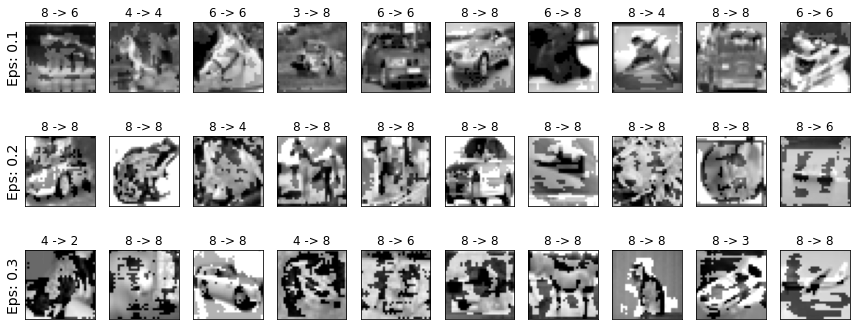

In [ ]:
cnt = 0
plt.figure(figsize=(12,5))
for i in range(len(epsilons)):
    for j in range(10):
        cnt += 1
        plt.subplot(len(epsilons),10,cnt)
        plt.xticks([], [])
        plt.yticks([], [])
        if j == 0:
            plt.ylabel("Eps: {}".format(epsilons[i]), fontsize=14)
        orig,adv,ex = examples[i][j]
        plt.title("{} -> {}".format(orig[1].item(), adv[1].item()))
        plt.imshow(ex[1], cmap="gray")
plt.tight_layout()
plt.show()
              

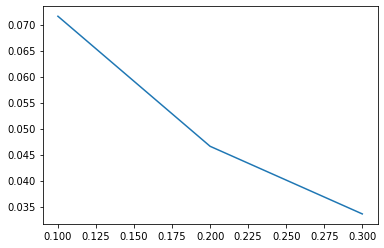

In [ ]:
plt.plot(epsilons, accuracies)

In [ ]:
acc, ex, adv_dataset = adv_gen(model, device, test_loader, 0)

In [ ]:
acc

tensor(0.1273)

In [ ]:
! pip install torchattacks

     |████████████████████████████████| 102 kB 3.4 MB/s 


In [ ]:
import torchattacks

In [ ]:
# Function to Generate advesarial examples using PGD

def adv( model, device, test_loader, epsilon ):

    # Accuracy counter
    correct = 0
    adv_examples = []
    adv_dataset=[]
    atk = torchattacks.PGDL2(model, eps=epsilon, alpha=2/255, steps=10)
    # Loop over all examples in test set
    for data, target in test_loader:

        # Send the data and label to the device
        data, target = data.to(device), target.to(device)
        #print(data.shape)
        # Set requires_grad attribute of tensor. Important for Attack
        data.requires_grad = True

        # Forward pass the data through the model
        logits, recs, mus, logvars = model(data)
        init_pred = logits.max(1, keepdim=True)[1] # get the index of the max log-probability

        # If the initial prediction is wrong, dont bother attacking, just move on
        #if init_pred.item() != target.item():
            #continue

        # Calculate the loss
        loss = abs_loss_function(data, target, recs, mus, logvars, args.beta)

        # Zero all existing gradients
        model.zero_grad()

        # Calculate gradients of model in backward pass
        loss.backward()

        # Collect datagrad
        data_grad = data.grad.data

        # Call FGSM Attack
        perturbed_data = atk(data, target)
        # Re-classify the perturbed image
        logits, recs, mus, logvars= model(perturbed_data)
        # Check for success
        final_pred = logits.max(1, keepdim=True)[1] # get the index of the max log-probability

        correct += final_pred.eq(target.data.view_as(final_pred)).long().cpu().sum()
        adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
        adv_examples.append((init_pred, final_pred, adv_ex))
        adv_dataset.append((adv_ex , final_pred.numpy()))

    # Calculate final accuracy for this epsilon
    final_acc = correct/float(len(test_dataset))
    #print("Epsilon: {}\tTest Accuracy = {} / {} = {}".format(epsilon, correct, len(test_dataset), final_acc))
    # Return the accuracy and an adversarial example
    return final_acc, adv_examples, adv_dataset

In [ ]:
import time
epsilons = [0.1, 0.2, 0.3]
model.eval()
accuracies = []
examples = []
adversarial_dataset=[]
# Run test for each epsilon
for eps in epsilons:
    start= time.time()
    acc, ex, adv_dataset = adv(model, device, test_loader, eps)
    end= time.time()
    # total time taken
    print(f"Runtime of the attack is {end - start} sec")
    examples.append(ex)
    accuracies.append(acc)
    adversarial_dataset.append(adv_dataset)
    print("Epsilon: {}\t Accuracy = {}".format(eps, acc))